In [370]:
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Reading in the EmoLex

In [354]:
filepath = "../NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


## Reading in Game of Thrones' subtitles

In [355]:
filenames = glob.glob("Got_s01_s07_subs/*/*.srt")
filenames[:5]

['Got_s01_s07_subs/s01/1x01 - Winter is Coming.srt',
 'Got_s01_s07_subs/s01/1x02 - The Kingsroad.srt',
 'Got_s01_s07_subs/s01/1x03 - Lord Snow.srt',
 'Got_s01_s07_subs/s01/1x04 - Cripples  Bastards  and Broken Things.srt',
 'Got_s01_s07_subs/s01/1x05 - The Wolf and the Lion.srt']

In [356]:
got_episodes = []

for filename in filenames:
    got_episodes.append({
        'content': open(filename).read(),
        'filename': filename,
        'title': re.search(r'(?<=- ).*(?=\.)', filename)[0],
        'season': int(re.search(r'\d(?=x)', filename)[0]),
        'episode': int(re.search(r'(?<=x)\d\d', filename)[0])
    })

got_episodes_df = pd.DataFrame(got_episodes)
got_episodes_df.head(3)

,content,episode,filename,season,title
0,"1\n00:01:55,418 --> 00:01:58,420\nEasy, boy.\n...",1,Got_s01_s07_subs/s01/1x01 - Winter is Coming.srt,1,Winter is Coming
1,"﻿1\n00:00:04,652 --> 00:00:06,681\nThere was a...",2,Got_s01_s07_subs/s01/1x02 - The Kingsroad.srt,1,The Kingsroad
2,"﻿1\n00:00:00,727 --> 00:00:02,930\nStill not f...",3,Got_s01_s07_subs/s01/1x03 - Lord Snow.srt,1,Lord Snow


## TF-IDF

In [357]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(
    use_idf=False,
    norm='l1',
    vocabulary=emolex_df.word)
matrix = vec.fit_transform(got_episodes_df['content'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sentiment analysis

In [419]:
got_episodes_df['anger'] = wordcount_df[emolex_df[emolex_df['anger'] == 1]['word']].sum(axis=1)
got_episodes_df['joy'] = wordcount_df[emolex_df[emolex_df['joy'] == 1]['word']].sum(axis=1)
got_episodes_df['sadness'] = wordcount_df[emolex_df[emolex_df['sadness'] == 1]['word']].sum(axis=1)
got_episodes_df['positive'] = wordcount_df[emolex_df[emolex_df['positive'] == 1]['word']].sum(axis=1)
got_episodes_df['negative'] = wordcount_df[emolex_df[emolex_df['negative'] == 1]['word']].sum(axis=1)

In [397]:
got_episodes_df.loc[got_episodes_df['joy'].nlargest(10).index][['season', 'episode', 'title']]

,season,episode,title
31,4,2,The Lion and the Rose
52,6,3,Oathbreaker
42,5,3,High Sparrow
55,6,6,Blood of My Blood
27,3,8,Second Sons
34,4,5,First of His Name
48,5,9,The Dance of Dragons
19,2,10,Valar Morghulis
25,3,6,The Climb
43,5,4,Sons of the Harpy


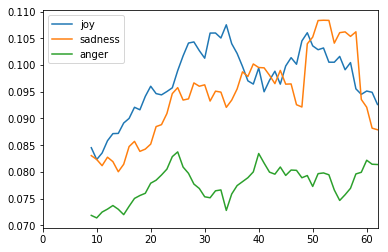

In [423]:
ax = got_episodes_df.rolling(10).mean().plot(y='joy', use_index=True)
got_episodes_df.rolling(10).mean().plot(y='sadness', use_index=True, ax=ax)
got_episodes_df.rolling(10).mean().plot(y='anger', use_index=True, ax=ax)

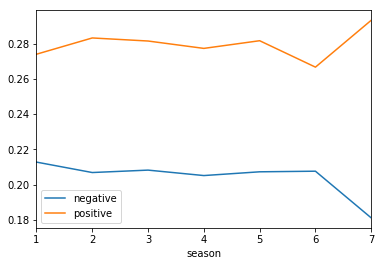

In [360]:
ax = got_episodes_df.groupby('season')['negative'].mean().plot(use_index=True, legend=True)
got_episodes_df.groupby('season')['positive'].mean().plot(use_index=True, ax=ax, legend=True)

## More specific analysis

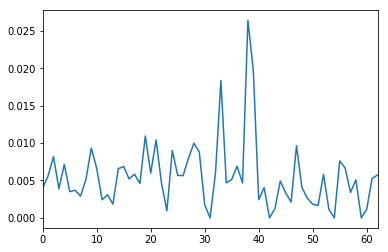

In [361]:
got_episodes_df['kill'] = wordcount_df[['kill']].sum(axis=1)
got_episodes_df['kill'].plot()

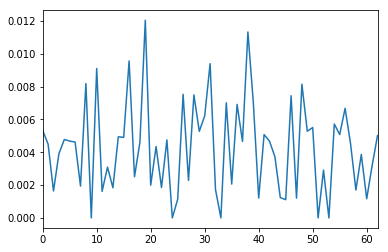

In [362]:
got_episodes_df['love'] = wordcount_df[['love']].sum(axis=1)
got_episodes_df['love'].plot()

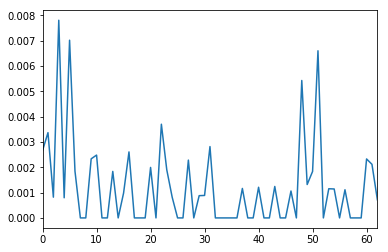

In [388]:
got_episodes_df['dragon'] = wordcount_df[['dragon']].sum(axis=1)
got_episodes_df['dragon'].plot()

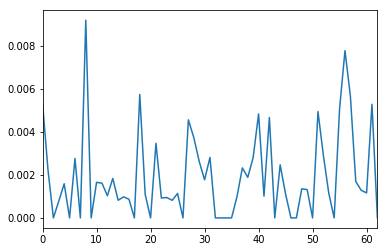

In [364]:
got_episodes_df['drink'] = wordcount_df[['drink']].sum(axis=1)
got_episodes_df['drink'].plot()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

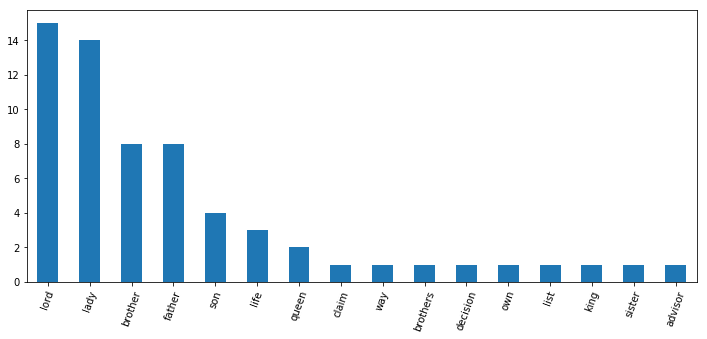

In [381]:
got_episodes_df['my'] = got_episodes_df.apply(
    lambda x: [val.lower() for val in re.findall('(?<= my )[a-zA-Z]+', x['content'])],
    axis=1)
got_episodes_df['my'] = got_episodes_df.apply(lambda x: pd.Series(x['my']).value_counts().argmax(), axis=1)
ax = got_episodes_df['my'].value_counts().plot(kind='bar', figsize=(12,5))
plt.xticks(rotation=70)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

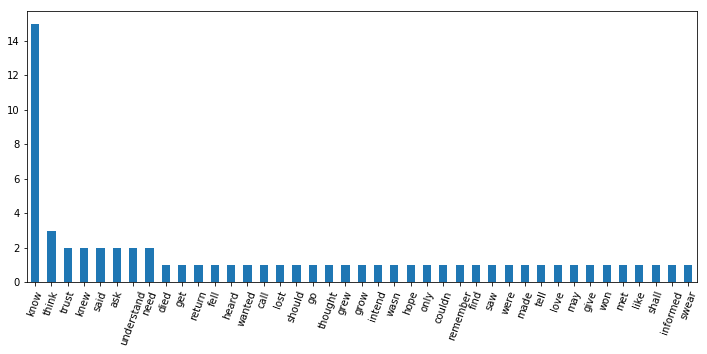

In [380]:
def exclude_words(list, words_to_exclude):
    new_list = []
    for l in list:
        if l not in words:
            new_list.append(l)
    return new_list

words = ['was', 'have', 'can', 'don', 'just', 'am', 'will', 'had', 'do', 'want', 'could', 'would', 'never', 'ever', 'didn', 'did']

got_episodes_df['I'] = got_episodes_df.apply(
    lambda x: [val.lower() for val in re.findall('(?<= I )[a-zA-Z]+', x['content'])],
    axis=1)
got_episodes_df['I'] = got_episodes_df.apply(
    lambda x: pd.Series(exclude_words(x['I'], words)).value_counts().argmax(),
    axis=1)
ax = got_episodes_df['I'].value_counts().plot(kind='bar', figsize=(12,5))
plt.xticks(rotation=70)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

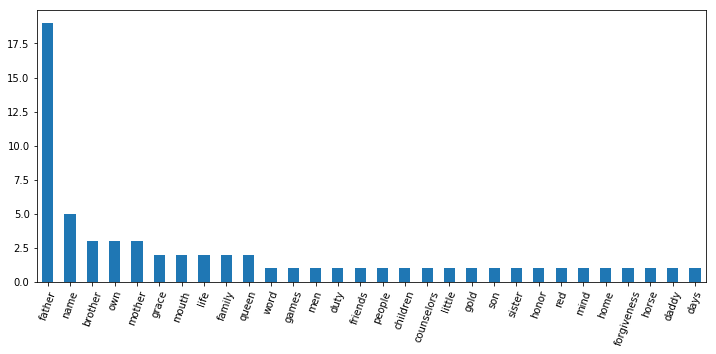

In [379]:
got_episodes_df['your'] = got_episodes_df.apply(
    lambda x: [val.lower() for val in re.findall('(?<= your )[a-zA-Z]+', x['content'])],
    axis=1)
got_episodes_df['your'] = got_episodes_df.apply(
    lambda x: pd.Series(x['your']).value_counts().argmax(),
    axis=1)
ax = got_episodes_df['your'].value_counts().plot(kind='bar', figsize=(12,5))
plt.xticks(rotation=70)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

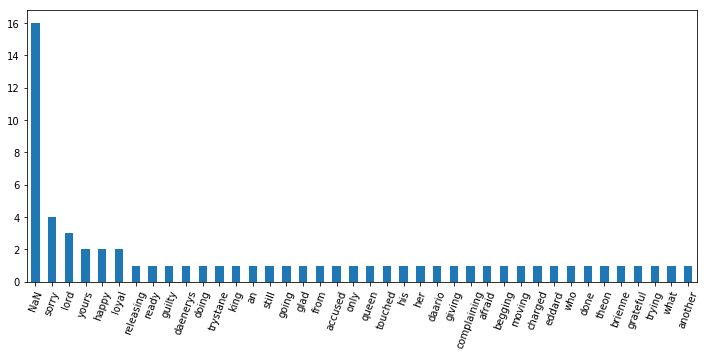

In [378]:
words = ['a', 'i', 'the', 'not', 'your', 'so', 'very', 'in', 'about']

got_episodes_df['am'] = got_episodes_df.apply(
    lambda x: [val.lower() for val in re.findall('(?<= am )[a-zA-Z]+', x['content'])],
    axis=1)
got_episodes_df['am'] = got_episodes_df.apply(
    lambda x: pd.Series(exclude_words(x['am'], words)).value_counts().argmax() if len(exclude_words(x['am'], words)) > 0 else 'NaN',
    axis=1)
ax = got_episodes_df['am'].value_counts().plot(kind='bar', figsize=(12,5))
plt.xticks(rotation=70)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

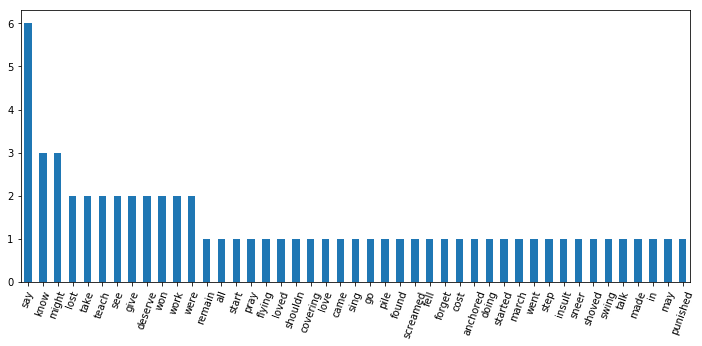

In [406]:
words = ['was', 'have', 'can', 'don', 'just', 'are', 'will', 'had', 'do', 'want', 'could', 'would', 'never', 'ever', 'didn', 'did']

got_episodes_df['they'] = got_episodes_df.apply(
    lambda x: [val.lower() for val in re.findall('(?<= they )[a-zA-Z]+', x['content'])],
    axis=1)
got_episodes_df['they'] = got_episodes_df.apply(
    lambda x: pd.Series(exclude_words(x['they'], words)).value_counts().argmax() if len(exclude_words(x['they'], words)) > 0 else 'NaN',
    axis=1)
ax = got_episodes_df['they'].value_counts().plot(kind='bar', figsize=(12,5))
plt.xticks(rotation=70)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text xticklabel objects>)

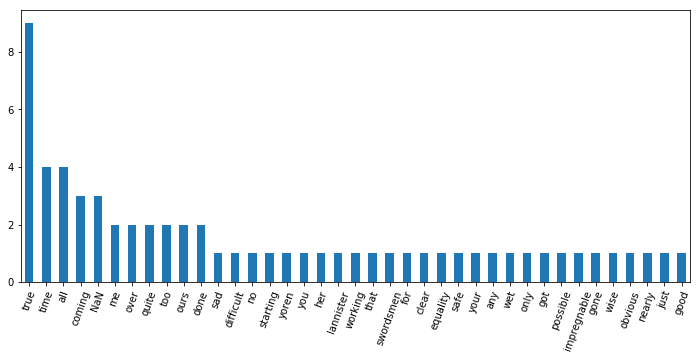

In [424]:
words = ['a', 'the', 'not', 'like']

got_episodes_df['it'] = got_episodes_df.apply(
    lambda x: [val.lower() for val in re.findall('(?<= it.s )[a-zA-Z]+', x['content'])],
    axis=1)
got_episodes_df['it'] = got_episodes_df.apply(
    lambda x: pd.Series(exclude_words(x['it'], words)).value_counts().argmax() if len(exclude_words(x['it'], words)) > 0 else 'NaN',
    axis=1)
ax = got_episodes_df['it'].value_counts().plot(kind='bar', figsize=(12,5))
plt.xticks(rotation=70)